In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5994368134398930075
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4638497188715449484
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/residential_power_usage_2016_to_2020.csv')
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [5]:
df.tail()

,StartDate,Value (kWh),day_of_week,notes
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday
35951,2020-07-07 23:00:00,1.809,1,weekday


In [6]:
df.shape

(35952, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [8]:
df.isnull().sum()

StartDate      0
Value (kWh)    0
day_of_week    0
notes          0
dtype: int64

In [9]:
time = pd.date_range(start='1/1/2016 00:00:00',periods=35952,freq='H')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['StartDate','day_of_week','notes'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [10]:
df.columns=['value']

In [11]:
#df = df.iloc[26304:,]
df.shape

(35952, 1)

In [12]:
df.head()

,value
time_stamp,
2016-01-01 00:00:00,1.057
2016-01-01 01:00:00,1.171
2016-01-01 02:00:00,0.560
2016-01-01 03:00:00,0.828
2016-01-01 04:00:00,0.932


In [13]:
df.tail()

,value
time_stamp,
2020-02-06 19:00:00,1.307
2020-02-06 20:00:00,2.872
2020-02-06 21:00:00,2.138
2020-02-06 22:00:00,2.199
2020-02-06 23:00:00,1.809


In [14]:
plt.rcParams['figure.figsize'] = [15,8]

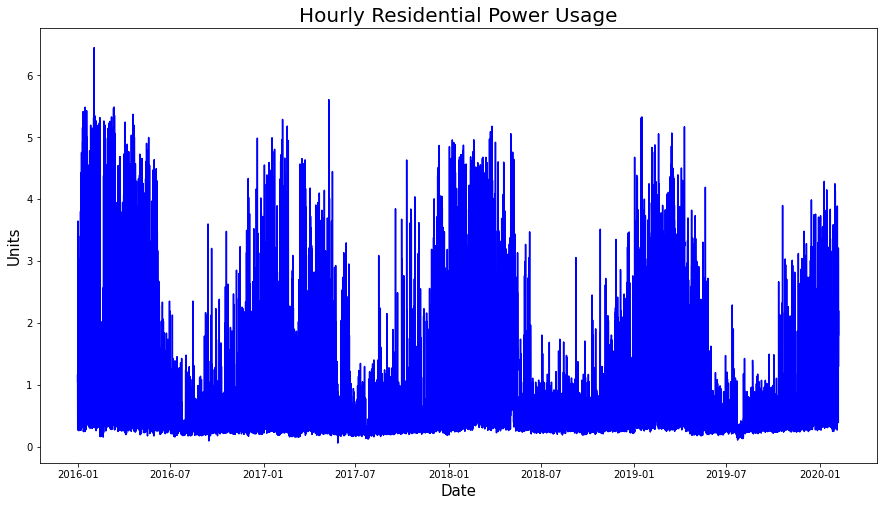

In [15]:
plt.plot(df,color='blue')
plt.title('Hourly Residential Power Usage',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [16]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [17]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['value'] = df['value'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [18]:
#Split data set into testing dataset and train dataset
train_size = 32000
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 23
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(31977, 1, 23)
(31977,)
(3929, 1, 23)
(3929,)


In [20]:
trainX

array([[[0.24003448, 0.25611094, 0.16994673, ..., 0.3976966 ,
         0.5102319 , 0.51319337]],

       [[0.25611094, 0.16994673, 0.20774052, ..., 0.5102319 ,
         0.51319337, 0.34396744]],

       [[0.16994673, 0.20774052, 0.22240676, ..., 0.51319337,
         0.34396744, 0.2716233 ]],

       ...,

       [[0.21676591, 0.18249765, 0.1743184 , ..., 0.13370417,
         0.13440928, 0.14822939]],

       [[0.18249765, 0.1743184 , 0.1593701 , ..., 0.13440928,
         0.14822939, 0.15697274]],

       [[0.1743184 , 0.1593701 , 0.14907552, ..., 0.14822939,
         0.15697274, 0.1775619 ]]], dtype=float32)

In [21]:
testX

array([[[0.12623002, 0.17319022, 0.13497336, ..., 0.13017863,
         0.13299906, 0.13158885]],

       [[0.17319022, 0.13497336, 0.1514729 , ..., 0.13299906,
         0.13158885, 0.14385772]],

       [[0.13497336, 0.1514729 , 0.14879349, ..., 0.13158885,
         0.14385772, 0.13412723]],

       ...,

       [[0.3950172 , 0.30137888, 0.31675023, ..., 0.27373862,
         0.2752899 , 0.49598873]],

       [[0.30137888, 0.31675023, 0.2527264 , ..., 0.2752899 ,
         0.49598873, 0.39247882]],

       [[0.31675023, 0.2527264 , 0.3718897 , ..., 0.49598873,
         0.39247882, 0.40108114]]], dtype=float32)

In [22]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [23]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
#from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('lstm_layer',min_value=8,max_value=128,step=8), activation="relu", input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.2)))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='resident_consum_2')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=36,
             validation_data=(testX, testY))

Trial 10 Complete [00h 04m 24s]
val_mape: 18.95372200012207

Best val_mape So Far: 18.64246940612793
Total elapsed time: 00h 36m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/resident_consum_2
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
lstm_layer: 72
first_recurrent_dropout: 0.4
dense_layer_1: 128
Dropout_rate: 0.30000000000000004
learning_rate: 0.0012525191047985907
Score: 18.64246940612793
Trial summary
Hyperparameters:
lstm_layer: 48
first_recurrent_dropout: 0.4
dense_layer_1: 104
Dropout_rate: 0.30000000000000004
learning_rate: 0.0010244242859496276
Score: 18.715389251708984
Trial summary
Hyperparameters:
lstm_layer: 64
first_recurrent_dropout: 0.6
dense_layer_1: 48
Dropout_rate: 0.4
learning_rate: 0.01091885407324276
Score: 18.95372200012207
Trial summary
Hyperparameters:
lstm_layer: 64
first_recurrent_dropout: 0.4
dense_layer_1: 80
Dropout_rate: 0.4
learning_rate: 0.005894468395199699
Score: 18.957490921020508
Trial summary
Hyperparameters:
lstm_layer: 40
first_recurrent_dropout: 0.4
dense_layer_1: 64
Dropout_rate: 0.2
learning_rate: 0.0068852328221466015
Score: 

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 24))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72)                27648     
                                                                 
 dense (Dense)               (None, 128)               9344      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 37,121
Trainable params: 37,121
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LeakyReLU, BatchNormalization

In [25]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_shape=(1,look_back),recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,activation='relu',recurrent_dropout=0.3))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.000012525191047985907)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 100)

Epoch 1/100
889/889 [==============================] - 14s 8ms/step - loss: 76.8757 - mape: 76.8757 - val_loss: 44.4770 - val_mape: 44.4770
Epoch 2/100
889/889 [==============================] - 6s 7ms/step - loss: 27.5870 - mape: 27.5870 - val_loss: 19.4671 - val_mape: 19.4671
Epoch 3/100
889/889 [==============================] - 6s 7ms/step - loss: 21.9837 - mape: 21.9837 - val_loss: 17.3824 - val_mape: 17.3824
Epoch 4/100
889/889 [==============================] - 6s 7ms/step - loss: 18.8782 - mape: 18.8782 - val_loss: 15.9288 - val_mape: 15.9288
Epoch 5/100
889/889 [==============================] - 6s 7ms/step - loss: 17.4597 - mape: 17.4597 - val_loss: 15.4599 - val_mape: 15.4599
Epoch 6/100
889/889 [==============================] - 6s 7ms/step - loss: 16.8979 - mape: 16.8979 - val_loss: 15.2730 - val_mape: 15.2730
Epoch 7/100
889/889 [==============================] - 6s 7ms/step - loss: 16.4707 - mape: 16.4707 - val_loss: 14.8804 - val_mape: 14.8804
Epoch 8/100
889/889 [=====

In [26]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [27]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 13.24 
Test MAPE : 12.73 


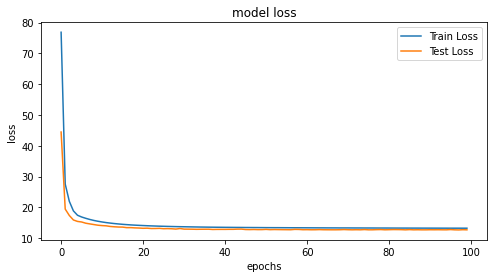

In [28]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [29]:
import seaborn as sns

In [32]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(31977,35906)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

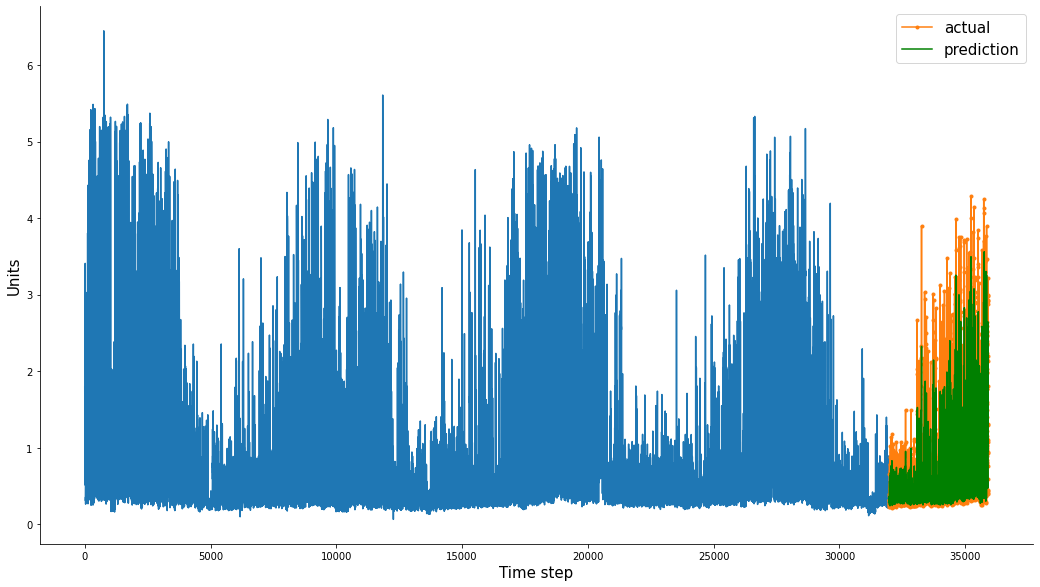

In [33]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)